In [1]:
from IPython.core.display import HTML
HTML(r"""
<style>
    * {
        font-family: monospace;
        font-size: 12px;
        line-height: normal;
    }
</style>
""")

In [2]:
from aiohttp import ClientSession
from datetime import datetime, timedelta
from typing import List
import asyncio
import matplotlib.pyplot as plt
import re
import time
import xmltodict

from tabulate import tabulate
import numpy as np
import pandas as pd
import pandasql as psql
import seaborn as sns

In [3]:
async def fetch_gold_price_data(url: str, session: ClientSession):
    """Crawl gold price data from an url"""
    resp = await session.request(method="GET", url=url)
    resp.raise_for_status()
    return await resp.text()

In [4]:
def parse_html_data(data: str, list_records: List[str], event_date: datetime):
    html_table_pattern = r"<table.*?<\/table>"
    record_by_brand = {}
    yyyy = event_date.strftime("%Y")
    yyyymm = event_date.strftime("%Y%m")
    yyyymmdd = event_date.strftime("%Y%m%d")
    for matched_string in re.findall(pattern=html_table_pattern, string=data):
        tbl = xmltodict.parse(xml_input=matched_string)
        if len(tbl["table"]["thead"]["tr"]["th"]) == 3 \
            and tbl["table"]["thead"]["tr"]["th"]["#text"] == "Lịch sử giá vàng Hà Nội" \
            and len(tbl["table"]["tbody"]["tr"]) > 1:
            rows = tbl["table"]["tbody"]["tr"][1:]  # Skip header of table
            current_brand = ""
            for row in rows:
                event = row["td"]
                if len(row["td"]) == 4: # data of new brand appears
                    current_brand = event[0]["#text"]
                    event = event[1:]
                buy_price = event[0]["#text"]
                sell_price = event[1]["#text"]
                update_time = event[2]["#text"]
                if not record_by_brand.get(current_brand):
                    record_by_brand[current_brand] = {
                        "year": yyyy,
                        "month": yyyymm,
                        "event_date": yyyymmdd,
                        "brand": current_brand,
                        "buy_price": buy_price,
                        "sell_price": sell_price,
                        "update_time": update_time,
                    }
                elif record_by_brand[current_brand]["update_time"] < update_time:
                    record_by_brand[current_brand] = {
                        "year": yyyy,
                        "month": yyyymm,
                        "event_date": yyyymmdd,
                        "brand": current_brand,
                        "buy_price": buy_price,
                        "sell_price": sell_price,
                        "update_time": update_time,
                    }
            break
    if (count := len(record_by_brand.keys())) > 0:
        global audit_record_number
        audit_record_number += count
        list_records.extend([v for _, v in record_by_brand.items()])
        # print(f"{event_date}: {count}")
    else:
        global audit_nodata_date_number
        audit_nodata_date_number += 1
        # print(event_date)

In [5]:
async def bulk_crawl_gold_prices(event_date: datetime, session: ClientSession, list_records: List[str]):
    pnj_url = "https://giavang.pnj.com.vn/history?gold_history_day={day}&gold_history_month={month}&gold_history_year={year}"
    data = await fetch_gold_price_data(
        url=pnj_url.format(day=str(event_date.day).zfill(2), month=str(event_date.month).zfill(2), year=event_date.year),
        session=session,
    )
    parse_html_data(data=data, list_records=list_records, event_date=event_date)


In [6]:
async def main(start_date: datetime, end_date: datetime, list_records: List[str]):
    async with ClientSession() as session:
        tasks = []
        target_date = start_date
        while target_date <= end_date:
            tasks.append(
                bulk_crawl_gold_prices(
                    session=session,
                    list_records=list_records,
                    event_date=target_date,
                )
            )
            target_date += timedelta(days=1)
        await asyncio.gather(*tasks)


In [7]:
audit_record_number = 0
audit_nodata_date_number = 0
list_records = []
start_date = datetime(year=2024, month=4, day=8)
# end_date = datetime(year=2023, month=12, day=31)
end_date = datetime.now()
await main(start_date=start_date, end_date=end_date, list_records=list_records)

In [8]:
if (delta := audit_record_number - len(list_records)) == 0:
    print(f"Number of records is eligible: {len(list_records)}")
    print(f"Number of days having no-data: {audit_nodata_date_number}")
else:
    print(f"Number of records is incorrect: audit_record_number={audit_record_number} vs len_records={len(list_records)}, delta={delta}")

Number of records is eligible: 4
Number of days having no-data: 0


In [9]:
148/2 + 19 - 31 - 29-31

2.0

In [10]:
df_gold_prices = pd.DataFrame.from_dict(list_records).sort_values(by=["event_date", "brand"], ascending=False).reset_index(drop=True)
df_gold_prices.head(n=5)

,year,month,event_date,brand,buy_price,sell_price,update_time
0,2024,202404,20240409,SJC,80.900,82.950,09/04/2024 10:18:27
1,2024,202404,20240409,PNJ,73.200,74.650,09/04/2024 10:18:27
2,2024,202404,20240408,SJC,80.300,82.300,08/04/2024 16:38:46
3,2024,202404,20240408,PNJ,72.900,74.350,08/04/2024 16:38:46


In [11]:
df_gold_prices.tail(n=5)

,year,month,event_date,brand,buy_price,sell_price,update_time
0,2024,202404,20240409,SJC,80.900,82.950,09/04/2024 10:18:27
1,2024,202404,20240409,PNJ,73.200,74.650,09/04/2024 10:18:27
2,2024,202404,20240408,SJC,80.300,82.300,08/04/2024 16:38:46
3,2024,202404,20240408,PNJ,72.900,74.350,08/04/2024 16:38:46


In [12]:
df_gold_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   year         4 non-null      object
 1   month        4 non-null      object
 2   event_date   4 non-null      object
 3   brand        4 non-null      object
 4   buy_price    4 non-null      object
 5   sell_price   4 non-null      object
 6   update_time  4 non-null      object
dtypes: object(7)
memory usage: 356.0+ bytes


In [13]:
df_gold_prices.to_csv(path_or_buf=f"./data/gold_prices/{end_date.strftime('%Y%m%d')}-{start_date.strftime('%Y%m%d')}.csv", index=False)

In [15]:
li_data = []
li_files = [
    "./data/gold_prices/20240401-20150101.csv",
    "./data/gold_prices/20240407-20240401.csv",
    "./data/gold_prices/20240409-20240408.csv",
]
for i in li_files:
    li_data.append(pd.read_csv(filepath_or_buffer=i))
df = pd.concat(li_data, axis=0, ignore_index=True)

In [16]:
df.head(n=5)

,year,month,event_date,brand,buy_price,sell_price,update_time
0,2024,202404,20240401,SJC,78.3,80.80,01/04/2024 14:59:52
1,2024,202404,20240401,PNJ,69.6,70.85,01/04/2024 14:59:52
2,2024,202403,20240330,SJC,78.2,80.60,30/03/2024 12:07:06
3,2024,202403,20240330,PNJ,69.3,70.50,30/03/2024 12:07:06
4,2024,202403,20240329,SJC,78.8,80.80,29/03/2024 14:14:27


In [17]:
print(
    tabulate(
        tabular_data=df.query(f"brand == 'SJC' and event_date >= 20240101"),
        headers="keys",
        tablefmt="psql",
        showindex=False,
    )
)

+--------+---------+--------------+---------+-------------+--------------+---------------------+
|   year |   month |   event_date | brand   |   buy_price |   sell_price | update_time         |
|--------+---------+--------------+---------+-------------+--------------+---------------------|
|   2024 |  202404 |     20240401 | SJC     |       78.3  |        80.8  | 01/04/2024 14:59:52 |
|   2024 |  202403 |     20240330 | SJC     |       78.2  |        80.6  | 30/03/2024 12:07:06 |
|   2024 |  202403 |     20240329 | SJC     |       78.8  |        80.8  | 29/03/2024 14:14:27 |
|   2024 |  202403 |     20240328 | SJC     |       79.1  |        81.1  | 28/03/2024 13:08:45 |
|   2024 |  202403 |     20240327 | SJC     |       78.8  |        80.9  | 27/03/2024 16:35:01 |
|   2024 |  202403 |     20240326 | SJC     |       78    |        80.1  | 26/03/2024 16:33:53 |
|   2024 |  202403 |     20240325 | SJC     |       77.8  |        79.8  | 25/03/2024 13:32:05 |
|   2024 |  202403 |     20240

In [16]:
df.query("brand == 'SJC'").groupby(by=["year", "brand"]).agg({
    "sell_price": ["max", "min", np.ptp,]
}).sort_values(by="year", ascending=False)

sell_price              
                  max    min    ptp
year brand                         
2024 SJC        82.40  74.20   8.20
2023 SJC        79.60  66.50  13.10
2022 SJC        74.00  61.45  12.55
2021 SJC        61.80  54.50   7.30
2020 SJC        61.90  42.80  19.10
2019 SJC        42.90  36.26   6.64
2018 SJC        37.62  36.34   1.28
2017 SJC        37.75  36.18   1.57
2016 SJC        39.80  32.84   6.96
2015 SJC        35.81  32.75   3.06

In [85]:
df.query("brand == 'SJC' and year == 2019").groupby(by=["month", "brand"]).agg({
    "sell_price": ["max", "min", np.ptp,]
}).sort_values(by="month", ascending=False)

sell_price             
                    max    min   ptp
month  brand                        
201912 SJC        42.80  41.39  1.41
201911 SJC        42.20  41.30  0.90
201910 SJC        42.10  41.30  0.80
201909 SJC        42.90  41.75  1.15
201908 SJC        42.90  39.50  3.40
201907 SJC        40.10  38.36  1.74
201906 SJC        39.45  36.65  2.80
201905 SJC        36.51  36.26  0.25
201904 SJC        36.60  36.26  0.34
201903 SJC        36.85  36.56  0.29
201902 SJC        37.35  36.80  0.55
201901 SJC        37.05  36.53  0.52

<Axes: xlabel='event_date', ylabel='sell_price'>

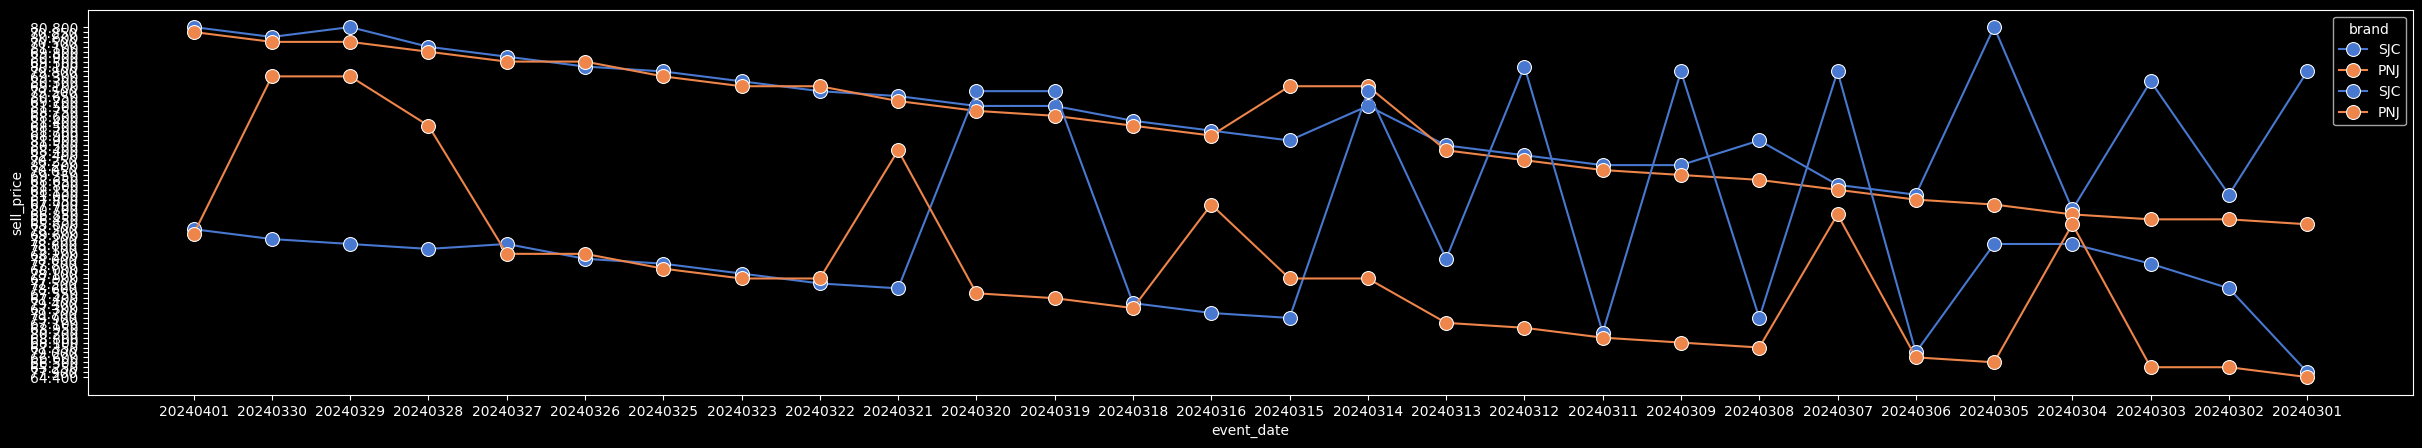

In [77]:
fig = plt.subplots(figsize=(30, 5))
sns.lineplot(
    x="event_date",
    y="sell_price",
    hue="brand",
    palette="muted",
    marker='.', markersize=20,
    data=df_gold_prices.query("event_date >= '20240301'"))
sns.lineplot(
    x="event_date",
    y="buy_price",
    hue="brand",
    palette="muted",
    # color='magenta',
    marker='.', markersize=20,
    data=df_gold_prices.query("event_date >= '20240301'"))